In [4]:
import pandas as pd
import os
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import math
import subprocess
from tqdm import tqdm
from glob import glob

In [2]:
category_order = ["inversion", "translocation", "duplication", "indel (>=50bp)", "syntenic_region", "not_aligned"]
category_order_v2 = ["Inversions", "Translocations", "Duplications", "Indels (>=50bp)", "Syntenic regions", "Not aligned"]
chr_natural_order = [f"chr{n}{hap}" for n in range(1, 19) for hap in ["A", "B"]]

## TE enrichment in SVs

In [484]:
def run_shell(command):
    subprocess.run(command, shell=True)

def calculate_feature_coverage_at_sv(feature_bed, sv_coords_bed):
    """
    reads in a TE bed that has four columns: chr, start, end, matched consensus TE.
    then calculate TE coverage by order or COS.
    """
    # read in intersect bed and takes number of overlapping bases in the last column
    df = pd.read_csv(feature_bed, sep="\t", header=None)
    df = df.iloc[:,[0,1,2,-1]]
    df.columns = ["chr", "feat_start", "feat_end", "overlap_len"]
    # #get feature bed for length to compute coverage in feature region
    sv = pd.read_csv(sv_coords_bed, sep="\t", header=None, usecols=(0,1,2))
    sv.columns = ["chr", "start", "end"]
    sv["sv_len"] = sv["end"]-sv["start"]
    sv = sv.groupby("chr")["sv_len"].sum().reset_index()
    df = pd.merge(df, sv[["chr", "sv_len"]], on="chr")
    df = df.groupby(["chr", "sv_len"])["overlap_len"].sum().reset_index()
    df["coverage"] = (df["overlap_len"] / df["sv_len"]) * 100
    return df

def calculate_feat_coverage_diff(SV_feat_cov_df, nonSV_feat_cov_df):
    """
    calculates feature coverage difference by (SV - nonSV).
    """
    result = pd.merge(SV_feat_cov_df, nonSV_feat_cov_df, \
                      on=["chr"], suffixes=["_SV", "_nonSV"])
    result = result[["chr", "coverage_SV", "coverage_nonSV"]]
    result["coverage_diff"] = result["coverage_SV"]-result["coverage_nonSV"]
    return result

slopped SVs by 2kbp on both sides; nonSVs are the reverse of those

In [495]:
# !cat SV_hapA.bed SV_hapB.bed > SV.bed
# # slop SVs outwards by 2kbp to capture TEs nearby
# !bedtools slop -i SV.bed -g TE_enrichment/v3.9.chr.haplotype-paired.fasta.genomefile -b 2000 > TE_enrichment/SV.slop2k.bed 
# # merge slopped SV bed
# !sort -k1,1 -k2,2n TE_enrichment/SV.slop2k.bed | bedtools merge | cut -f1,2,3 > TE_enrichment/SV.merged.bed 
# # # get outside SV bed. no need to merge because it's subtracted by merged SV
# !bedtools subtract -a /media/ssd/rita/project/104e/SV_calling/l200b500c500/TE_enrichment/v3.9.chr.haplotype-paired.fasta.bed -b  TE_enrichment/SV.merged.bed  > TE_enrichment/nonSV.bed
# # # merge TE bed
# !sort -k1,1 -k2,2n TE_enrichment/TE.bed | bedtools merge | cut -f1,2,3 > TE_enrichment/TE.merged.bed 

# # # intersect TEs with SVs to generate SV TEs bed file. TE only counted in if overlapped >=50%.
# # # last columns report overlapping bases which will be used to calculate coverage
# !bedtools intersect -a TE_enrichment/TE.merged.bed  -b TE_enrichment/SV.merged.bed -wo > TE_enrichment/SV_TE.bed
# !bedtools intersect -f 1 -a TE_enrichment/TE.merged.bed -b TE_enrichment/nonSV.bed -wo > TE_enrichment/nonSV_TE.bed

In [543]:
def plot_te_coverage_difference(sv_te_bed, sv_coords_bed, non_sv_te_bed, non_sv_coords_bed, title, figsize=(2, 2.5)):
    observed_TE_coverage_at_SV = calculate_feature_coverage_at_sv(sv_te_bed, sv_coords_bed)
    observed_TE_coverage_at_nonSV = calculate_feature_coverage_at_sv(non_sv_te_bed, non_sv_coords_bed)
    # calculate TE coverage difference
    observed_TE_result = calculate_feat_coverage_diff(observed_TE_coverage_at_SV, observed_TE_coverage_at_nonSV)
    # sort by natural chromosome order
    observed_TE_result["chr"] = pd.Categorical(observed_TE_result["chr"], categories=chr_natural_order, ordered=True) 
    observed_TE_result = observed_TE_result.sort_values("chr")
    observed_TE_result_plot = pd.melt(observed_TE_result, id_vars="chr", value_vars=["coverage_SV", "coverage_nonSV"])
    observed_TE_result_plot.columns = ["chr", "variable", "% TE coverage"]
    plt.figure(figsize=figsize)
    ax = sns.boxplot(observed_TE_result_plot, y="% TE coverage", x="variable", palette="viridis")
    ax.set_xticklabels(["inside SV", "outside SV"])
    ax.set_xlabel("")
    ax.set_title(title)
    return observed_TE_result

/tmp/ipykernel_9233/3004076735.py:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.boxplot(observed_TE_result_plot, y="% TE coverage", x="variable", palette="viridis")
/tmp/ipykernel_9233/3004076735.py:13: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(["inside SV", "outside SV"])


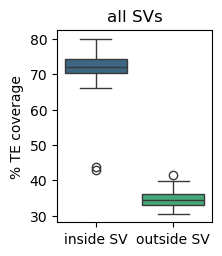

In [544]:
all_SVs_observed_result = plot_te_coverage_difference("TE_enrichment/SV_TE.bed", "TE_enrichment/SV.merged.bed", "TE_enrichment/nonSV_TE.bed", "TE_enrichment/nonSV.bed", "all SVs")

/tmp/ipykernel_9233/3004076735.py:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.boxplot(observed_TE_result_plot, y="% TE coverage", x="variable", palette="viridis")
/tmp/ipykernel_9233/3004076735.py:13: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(["inside SV", "outside SV"])
/tmp/ipykernel_9233/3004076735.py:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.boxplot(observed_TE_result_plot, y="% TE coverage", x="variable", palette="viridis")
/tmp/ipykernel_9233/3004076735.py:13: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using 

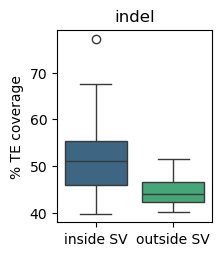

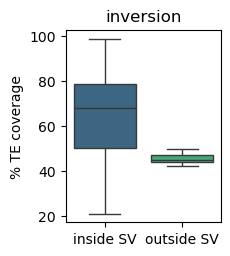

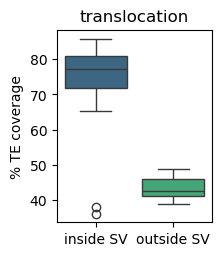

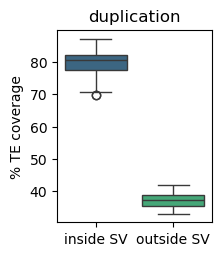

In [549]:
# for sv_type in ["indel", "inversion", "translocation", "duplication"]:
#     plot_te_coverage_difference(f"TE_enrichment/{sv_type}_TE.bed", f"TE_enrichment/SV_types/{sv_type}.slop2k.bed", 
#                                 f"TE_enrichment/non-{sv_type}_TE.bed", f"TE_enrichment/SV_types/non-{sv_type}.bed", sv_type)

# Assuming the compute_te_coverage_difference and plot_te_coverage_difference functions are already defined

# Calculate observed results for each SV type
indel_observed_result = plot_te_coverage_difference(
    sv_te_bed="TE_enrichment/indel_TE.bed", 
    sv_coords_bed="TE_enrichment/SV_types/indel.slop2k.bed", 
    non_sv_te_bed="TE_enrichment/non-indel_TE.bed", 
    non_sv_coords_bed="TE_enrichment/SV_types/non-indel.bed",
    title="indel"
)

inversion_observed_result = plot_te_coverage_difference(
    sv_te_bed="TE_enrichment/inversion_TE.bed", 
    sv_coords_bed="TE_enrichment/SV_types/inversion.slop2k.bed", 
    non_sv_te_bed="TE_enrichment/non-inversion_TE.bed", 
    non_sv_coords_bed="TE_enrichment/SV_types/non-inversion.bed",
    title="inversion"
)

translocation_observed_result = plot_te_coverage_difference(
    sv_te_bed="TE_enrichment/translocation_TE.bed", 
    sv_coords_bed="TE_enrichment/SV_types/translocation.slop2k.bed", 
    non_sv_te_bed="TE_enrichment/non-translocation_TE.bed", 
    non_sv_coords_bed="TE_enrichment/SV_types/non-translocation.bed",
    title="translocation"
)

duplication_observed_result = plot_te_coverage_difference(
    sv_te_bed="TE_enrichment/duplication_TE.bed", 
    sv_coords_bed="TE_enrichment/SV_types/duplication.slop2k.bed", 
    non_sv_te_bed="TE_enrichment/non-duplication_TE.bed", 
    non_sv_coords_bed="TE_enrichment/SV_types/non-duplication.bed",
    title="duplication"
)


#### permutation test

In [503]:
def permute_feat_bed(bed, assembly_fai_bed, outdir, shuffle_within, n=10):
    """
    randomly permutes feature bed file. shuffles features within chromosomes.
    """
    if not os.path.exists(outdir):
        os.makedirs(outdir)
    outfn_list = []
    for x in range(n):
        outfn = os.path.join(outdir, os.path.basename(bed).replace(".bed", f".random_permute.{x}.bed"))
        if shuffle_within == "chromosome":
            param = "-chrom"
        elif shuffle_within == "genome":
            param =""
        cmd = f"bedtools shuffle -seed {x} -i {bed} -g {assembly_fai_bed} {param} > {outfn}"
        outfn_list.append(outfn)
        run_shell(cmd)
    return outfn_list

def get_feat_bed_at_sv(feature_bed, sv_bed, outdir):
    """
    intersect feature bed and SV bed to extract features located in the feature.
    """
    outfn = os.path.join(outdir, f"{os.path.basename(sv_bed[:-4])}.{os.path.basename(feature_bed[:-4])}")+".bed"
    if "nonSV" not in feature_bed: 
        run_shell(f"bedtools intersect -a {feature_bed} -b {sv_bed} -wo > {outfn}")
    else:
        run_shell(f"bedtools intersect -f 1 -a {feature_bed} -b {sv_bed} -wo > {outfn}")
    return outfn

def get_covdiff_p_value(perm_results, observed_result, chrom):
    expected_vals = np.array([df[df["chr"]==chrom]["coverage_diff"].iloc[0] for df in perm_results])
    observed_val = observed_result[observed_result["chr"]==chrom]["coverage_diff"].iloc[0]
    # turns both into aboslute values to look at both tails.
    abs_expected_vals = np.abs(expected_vals)
    abs_observed_val = np.abs(observed_val)
    expected_vals_extreme_as_observed = abs_expected_vals[abs_expected_vals>=abs_observed_val]
    pval = len(expected_vals_extreme_as_observed)/len(expected_vals)
    return expected_vals, observed_val, pval

In [ ]:
#permuted_bed_list = permute_TE_bed("TE_enrichment/TE.merged.bed", "TE_enrichment/v3.9.chr.haplotype-paired.fasta.genomefile", "TE_enrichment/permute_bed", n=5000)

In [538]:
def calculate_permuted_TE_coverage_diff(sv_bed, nonsv_bed, permuted_bed_list, output_dir="TE_enrichment/permute_bed"):
    perm_TE_SV_vs_nonSV_results = []
    counter = 1
    for permuted_bed in permuted_bed_list:
        permuted_TE_at_SV_fn = get_feat_bed_at_sv(permuted_bed, sv_bed, output_dir)
        permuted_TE_at_nonSV_fn = get_feat_bed_at_sv(permuted_bed, nonsv_bed, output_dir)
        permuted_TE_coverage_at_SV = calculate_feature_coverage_at_sv(permuted_TE_at_SV_fn, sv_bed)
        permuted_TE_coverage_at_nonSV = calculate_feature_coverage_at_sv(permuted_TE_at_nonSV_fn, nonsv_bed)
        result = calculate_feat_coverage_diff(permuted_TE_coverage_at_SV, permuted_TE_coverage_at_nonSV)
        if counter % 500 == 0:
            print(f"Progress: {counter}/{len(permuted_bed_list)}")
        perm_TE_SV_vs_nonSV_results.append(pd.DataFrame(result))
        counter += 1
    return perm_TE_SV_vs_nonSV_results

In [539]:
#all_SVs_perm_results = calculate_permuted_TE_coverage_diff("TE_enrichment/SV.merged.bed", "TE_enrichment/nonSV.bed", permuted_bed_list)
# inversion_perm_results = calculate_permuted_TE_coverage_diff("TE_enrichment/inversion_TE.bed", "TE_enrichment/non-inversion_TE.bed", permuted_bed_list)
# translocation_perm_results = calculate_permuted_TE_coverage_diff("TE_enrichment/translocation_TE.bed", "TE_enrichment/non-translocation_TE.bed", permuted_bed_list)
# duplication_perm_results = calculate_permuted_TE_coverage_diff("TE_enrichment/duplication_TE.bed", "TE_enrichment/non-duplication_TE.bed", permuted_bed_list)
# indel_perm_results = calculate_permuted_TE_coverage_diff("TE_enrichment/indel_TE.bed", "TE_enrichment/non-indel_TE.bed", permuted_bed_list)

Progress: 500/5000
Progress: 1000/5000
Progress: 1500/5000
Progress: 2000/5000
Progress: 2500/5000
Progress: 3000/5000
Progress: 3500/5000
Progress: 4000/5000
Progress: 4500/5000
Progress: 5000/5000
Progress: 500/5000
Progress: 1000/5000
Progress: 1500/5000
Progress: 2000/5000
Progress: 2500/5000
Progress: 3000/5000
Progress: 3500/5000
Progress: 4000/5000
Progress: 4500/5000
Progress: 5000/5000
Progress: 500/5000
Progress: 1000/5000
Progress: 1500/5000
Progress: 2000/5000
Progress: 2500/5000
Progress: 3000/5000
Progress: 3500/5000
Progress: 4000/5000
Progress: 4500/5000
Progress: 5000/5000
Progress: 500/5000
Progress: 1000/5000
Progress: 1500/5000
Progress: 2000/5000
Progress: 2500/5000
Progress: 3000/5000
Progress: 3500/5000
Progress: 4000/5000
Progress: 4500/5000
Progress: 5000/5000


In [540]:
# sv_bed = "TE_enrichment/SV.merged.bed"
# nonsv_bed = "TE_enrichment/nonSV.bed"
# perm_TE_SV_vs_nonSV_results = []
# counter = 1
# for permuted_bed in permuted_bed_list:
#     permuted_TE_at_SV_fn = get_feat_bed_at_sv(permuted_bed, sv_bed, "TE_enrichment/permute_bed")
#     permuted_TE_at_nonSV_fn = get_feat_bed_at_sv(permuted_bed, nonsv_bed, "TE_enrichment/permute_bed")
#     permuted_TE_coverage_at_SV = calculate_feature_coverage_at_sv(permuted_TE_at_SV_fn, sv_bed)
#     permuted_TE_coverage_at_nonSV = calculate_feature_coverage_at_sv(permuted_TE_at_nonSV_fn, nonsv_bed)
#     result = calculate_feat_coverage_diff(permuted_TE_coverage_at_SV, permuted_TE_coverage_at_nonSV)
#     counter += 1
#     if counter % 500 == 0:
#         print(f"progress: {counter}/{len(permuted_bed_list)}")
#     perm_TE_SV_vs_nonSV_results.append(pd.DataFrame(result))

Save data

In [541]:
# perm_TE_SV_vs_nonSV_results_hdf5 = "perm_TE_SV_vs_nonSV_results.h5"
# with pd.HDFStore(perm_TE_SV_vs_nonSV_results_hdf5, mode="w") as store:
#     for i,df in enumerate(perm_TE_SV_vs_nonSV_results):
#         store[f"df_{i}"] = df

inversion_perm_results_hdf5 = "inversion_perm_results.h5"
with pd.HDFStore(inversion_perm_results_hdf5, mode="w") as store:
    for i,df in enumerate(inversion_perm_results):
        store[f"df_{i}"] = df

translocation_perm_results_hdf5 = "translocation_perm_results.h5"
with pd.HDFStore(translocation_perm_results_hdf5, mode="w") as store:
    for i,df in enumerate(translocation_perm_results):
        store[f"df_{i}"] = df
        
duplication_perm_results_hdf5 = "duplication_perm_results.h5"
with pd.HDFStore(duplication_perm_results_hdf5, mode="w") as store:
    for i,df in enumerate(duplication_perm_results):
        store[f"df_{i}"] = df

indel_perm_results_hdf5 = "indel_perm_results.h5"
with pd.HDFStore(indel_perm_results_hdf5, mode="w") as store:
    for i,df in enumerate(indel_perm_results):
        store[f"df_{i}"] = df

load data

In [ ]:
# perm_TE_SV_vs_nonSV_results_hdf5 = "perm_TE_SV_vs_nonSV_results.h5"
# perm_TE_SV_vs_nonSV_results = []
# with pd.HDFStore(perm_TE_SV_vs_nonSV_results_hdf5, mode="r") as store:
#     for key in store.keys():
#         perm_TE_SV_vs_nonSV_results_df = pd.read_hdf(store, key)
#         perm_TE_SV_vs_nonSV_results.append(perm_TE_SV_vs_nonSV_results_df)

In [554]:
def plot_permuted_hist(perm_results, observed_result, sv_type):
    chr_count = 18
    fig, axs = plt.subplots(chr_count, 2, figsize=(6, 2*chr_count))
    for n in range(1, chr_count+1):
        for hap in ["A", "B"]:
            if hap == "A":
                col = 0
            else:
                col = 1
            te_perm_vals, te_obs_val, te_pval = get_covdiff_p_value(perm_results, observed_result, f"chr{n}{hap}")
            sns.histplot(te_perm_vals, ax=axs[n-1,col])
            axs[n-1,col].set_title(f'chr{n}{hap}', fontsize=10)
            axs[n-1,col].axvline(te_obs_val, color='r', )
            axs[n-1,col].text(0.95, 0.95, f'p-value: {te_pval}', ha='right', va='top', transform=axs[n-1,col].transAxes, fontsize=9)
            axs[n-1,col].set_xlabel("% TE coverage difference (Obs-Exp)", fontsize=9)
            axs[n-1,col].set_ylabel("Count", fontsize=9)
    plt.suptitle(f"Difference of permuted vs observed TE coverage at {sv_type}")
    plt.tight_layout(rect=[0, 0, 1, 0.98])

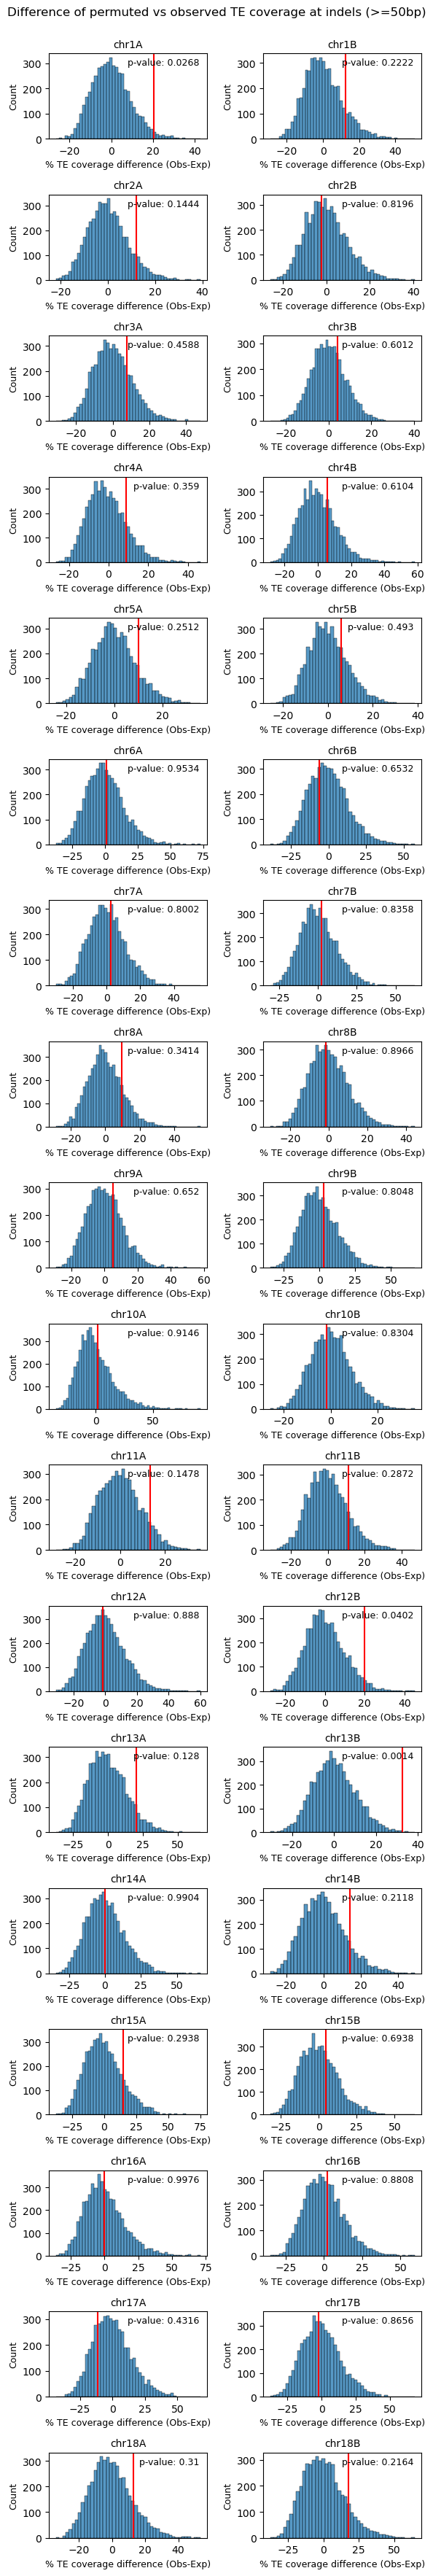

In [555]:
plot_permuted_hist(indel_perm_results, indel_observed_result, "indels (>=50bp)")

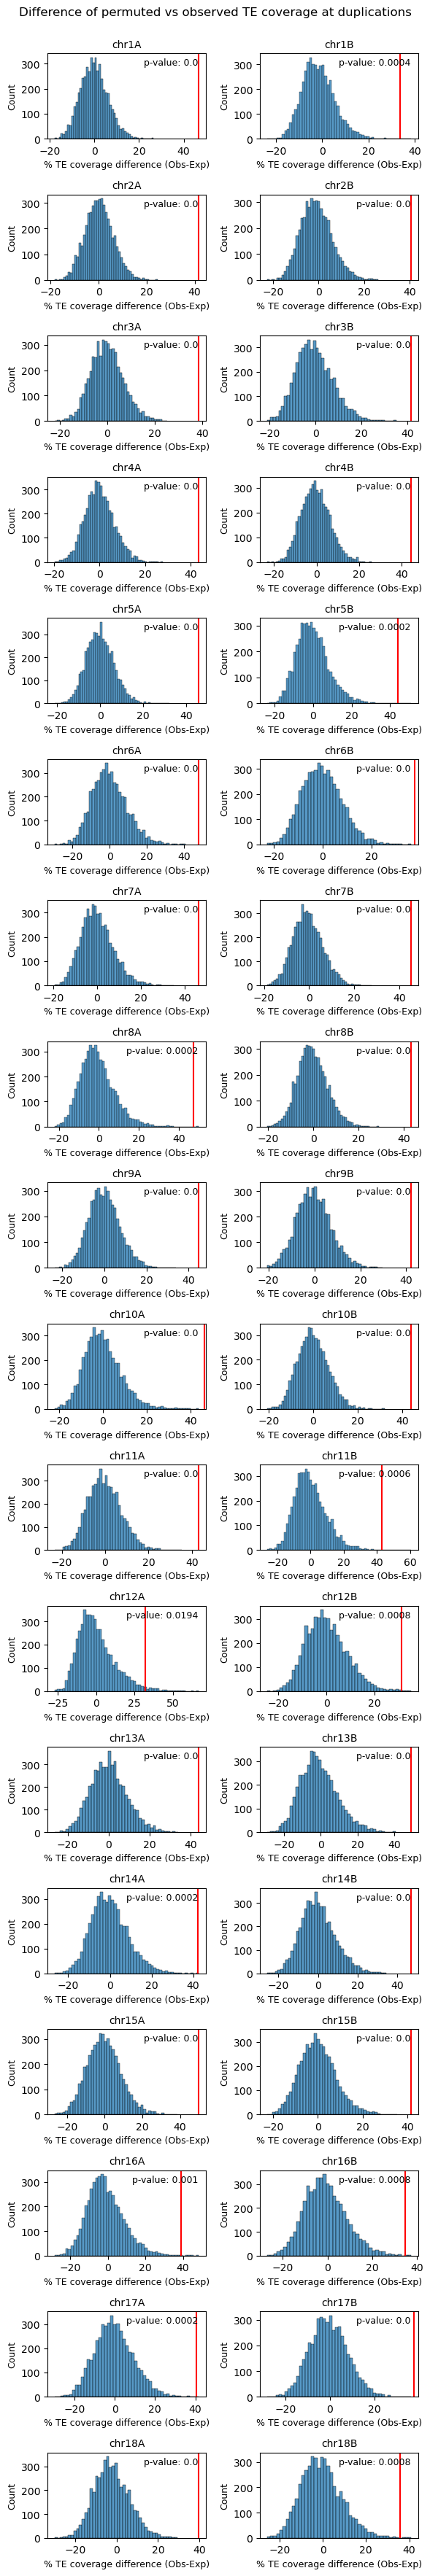

In [556]:
plot_permuted_hist(duplication_perm_results, duplication_observed_result, "duplications")

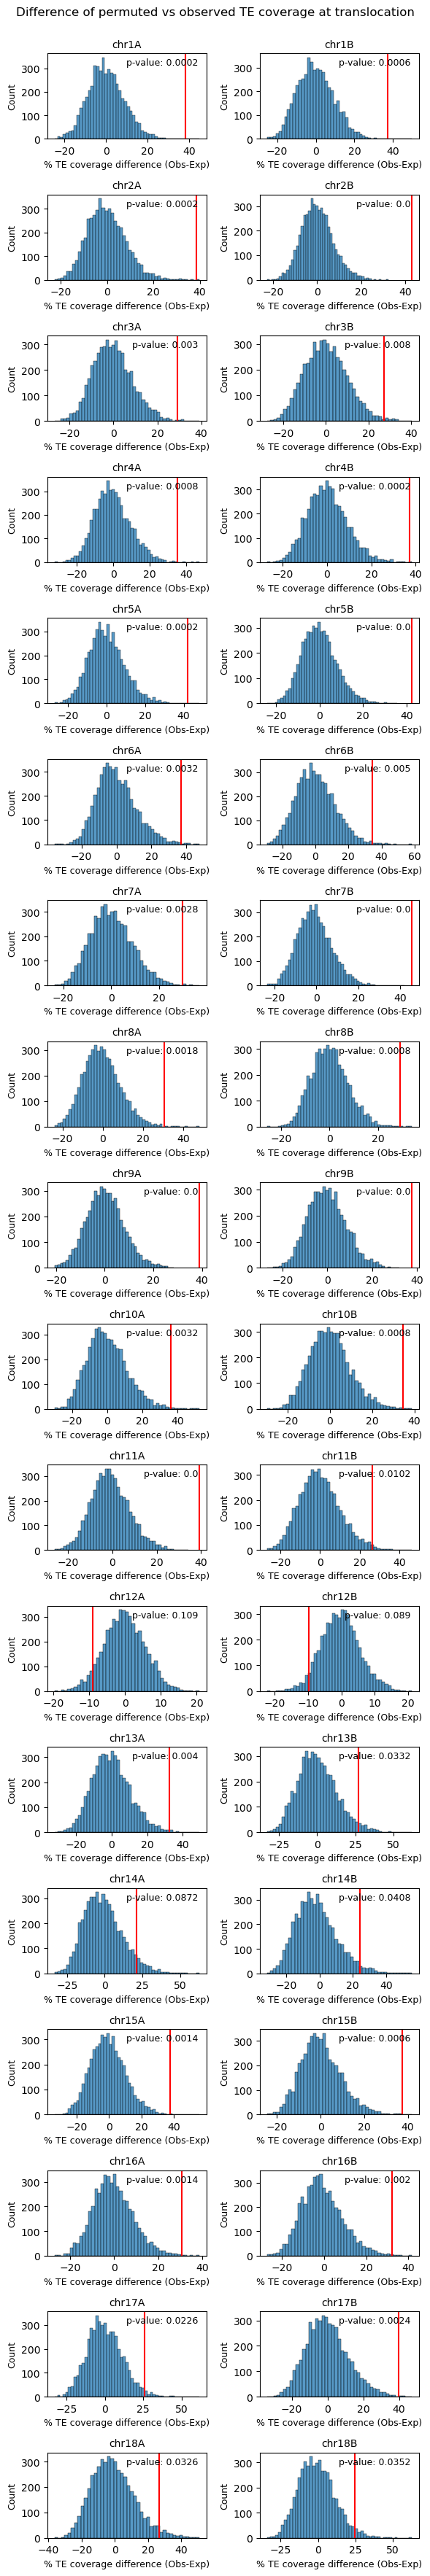

In [558]:
plot_permuted_hist(translocation_perm_results, translocation_observed_result, "translocation")

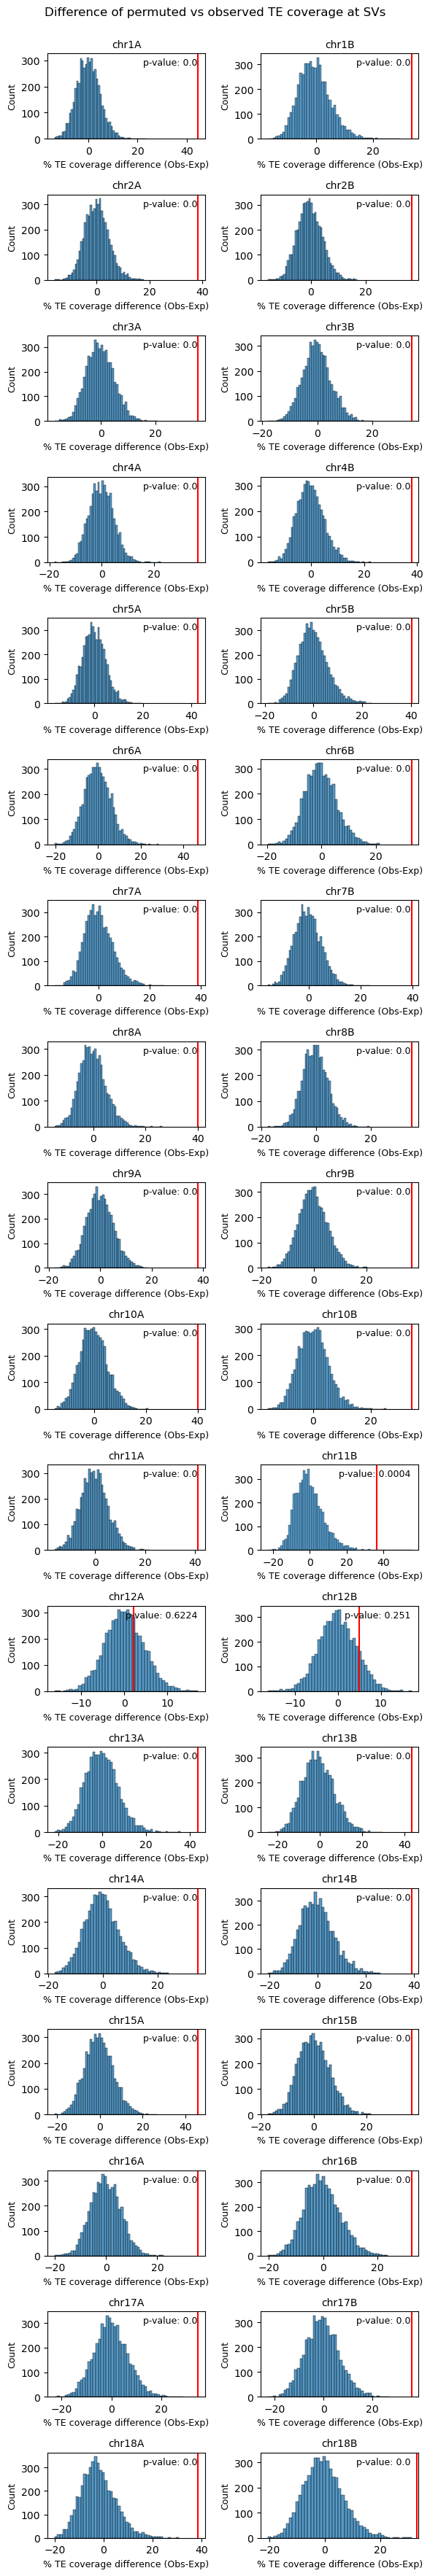

In [537]:
# all SVs
chr_count = 18
fig, axs = plt.subplots(chr_count, 2, figsize=(6, 2*chr_count))
for n in range(1, chr_count+1):
    for hap in ["A", "B"]:
        if hap == "A":
            col = 0
        else:
            col = 1
        te_perm_vals, te_obs_val, te_pval = get_covdiff_p_value(perm_TE_SV_vs_nonSV_results, observed_TE_result, f"chr{n}{hap}")
        sns.histplot(te_perm_vals, ax=axs[n-1,col])
        axs[n-1,col].set_title(f'chr{n}{hap}', fontsize=10)
        axs[n-1,col].axvline(te_obs_val, color='r', )
        axs[n-1,col].text(0.95, 0.95, f'p-value: {te_pval}', ha='right', va='top', transform=axs[n-1,col].transAxes, fontsize=9)
        axs[n-1,col].set_xlabel("% TE coverage difference (Obs-Exp)", fontsize=9)
        axs[n-1,col].set_ylabel("Count", fontsize=9)
plt.suptitle("Difference of permuted vs observed TE coverage at SVs")
plt.tight_layout(rect=[0, 0, 1, 0.98])

## Gene enrichment

In [219]:
!grep -P "\tgene\t" /media/ssd/rita/project/104e/gene_annotations/Puccinia_striiformis_Pst104E.gff3 | cut -f1,4,5 | awk '{print $1 "\t" $2-1 "\t" $3}' > gene_enrichment/gene.bed
!sort -k1,1 -k2,2n gene_enrichment/gene.bed | bedtools merge > gene_enrichment/gene.merged.bed
!bedtools intersect -f 0.7 -a gene_enrichment/gene.merged.bed -b TE_enrichment/SV.merged.bed -wo > gene_enrichment/SV_gene.bed
!bedtools intersect -f 0.7 -a gene_enrichment/gene.merged.bed -b TE_enrichment/nonSV.bed -wo > gene_enrichment/nonSV_gene.bed

/tmp/ipykernel_9233/3824696555.py:11: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(["inside SV", "outside SV"])


Text(0.5, 0, '')

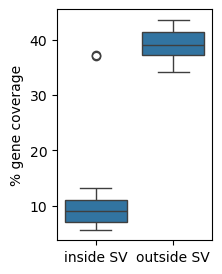

In [220]:
# generate observed result for actual data
observed_gene_coverage_at_SV = calculate_feature_coverage_at_sv("gene_enrichment/SV_gene.bed", "TE_enrichment/SV.merged.bed")
observed_gene_coverage_at_nonSV = calculate_feature_coverage_at_sv("gene_enrichment/nonSV_gene.bed", "TE_enrichment/nonSV.bed")
observed_result = calculate_feat_coverage_diff(observed_gene_coverage_at_SV, observed_gene_coverage_at_nonSV)
observed_result["chr"] = pd.Categorical(observed_result["chr"], categories=chr_natural_order, ordered=True) 
observed_result = observed_result.sort_values("chr")
observed_result_plot = pd.melt(observed_result, id_vars="chr", value_vars=["coverage_SV", "coverage_nonSV"])
observed_result_plot.columns = ["chr", "variable", "% gene coverage"]
plt.figure(figsize=(2, 3))
ax = sns.boxplot(observed_result_plot, y="% gene coverage", x="variable")
ax.set_xticklabels(["inside SV", "outside SV"])
ax.set_xlabel("")

## Secretome gene enrichment

In [221]:
# taking mRNA coordinates (same as genes) of secretome genes 
!cat /media/ssd/rita/project/104e/allele_analysis/secretome_effector_candidates/Puccinia_striiformis_Pst104E.secretome-effectors.TM_anno_cleaned.gff3 | cut -f1,4,5 | awk '{print $1 "\t" $2-1 "\t" $3}' > secretomeGene_enrichment/secretome.bed
!sort -k1,1 -k2,2n secretomeGene_enrichment/secretome.bed | bedtools merge > secretomeGene_enrichment/secretome.merged.bed
!bedtools intersect -f 0.7 -a secretomeGene_enrichment/secretome.merged.bed -b TE_enrichment/SV.merged.bed -wo > secretomeGene_enrichment/SV_secretomeGenes.bed
!bedtools intersect -f 0.7 -a secretomeGene_enrichment/secretome.merged.bed -b TE_enrichment/nonSV.bed -wo > secretomeGene_enrichment/nonSV_secretomeGenes.bed

/tmp/ipykernel_9233/3913721772.py:10: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(["inside SV", "outside SV"])


Text(0.5, 0, '')

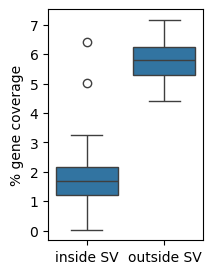

In [222]:
observed_gene_coverage_at_SV = calculate_feature_coverage_at_sv("secretomeGene_enrichment/SV_secretomeGenes.bed", "TE_enrichment/SV.merged.bed")
observed_gene_coverage_at_nonSV = calculate_feature_coverage_at_sv("secretomeGene_enrichment/nonSV_secretomeGenes.bed", "TE_enrichment/nonSV.bed")
observed_result = calculate_feat_coverage_diff(observed_gene_coverage_at_SV, observed_gene_coverage_at_nonSV)
observed_result["chr"] = pd.Categorical(observed_result["chr"], categories=chr_natural_order, ordered=True) 
observed_result = observed_result.sort_values("chr")
observed_result_plot = pd.melt(observed_result, id_vars="chr", value_vars=["coverage_SV", "coverage_nonSV"])
observed_result_plot.columns = ["chr", "variable", "% gene coverage"]
plt.figure(figsize=(2, 3))
ax = sns.boxplot(observed_result_plot, y="% gene coverage", x="variable")
ax.set_xticklabels(["inside SV", "outside SV"])
ax.set_xlabel("")

/tmp/ipykernel_9233/3913721772.py:10: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(["inside SV", "outside SV"])


Text(0.5, 0, '')

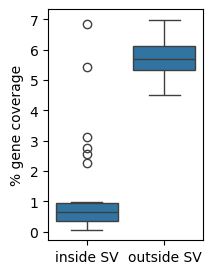

In [202]:
observed_gene_coverage_at_SV = calculate_feature_coverage_at_sv("secretomeGene_enrichment/SV_secretomeGenes.bed", "TE_enrichment/SV.merged.bed")
observed_gene_coverage_at_nonSV = calculate_feature_coverage_at_sv("secretomeGene_enrichment/nonSV_secretomeGenes.bed", "TE_enrichment/nonSV.bed")
observed_result = calculate_feat_coverage_diff(observed_gene_coverage_at_SV, observed_gene_coverage_at_nonSV)
observed_result["chr"] = pd.Categorical(observed_result["chr"], categories=chr_natural_order, ordered=True) 
observed_result = observed_result.sort_values("chr")
observed_result_plot = pd.melt(observed_result, id_vars="chr", value_vars=["coverage_SV", "coverage_nonSV"])
observed_result_plot.columns = ["chr", "variable", "% gene coverage"]
plt.figure(figsize=(2, 3))
ax = sns.boxplot(observed_result_plot, y="% gene coverage", x="variable")
ax.set_xticklabels(["inside SV", "outside SV"])
ax.set_xlabel("")

## CpG Methylation